In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from copy import deepcopy

In [2]:
def generate_plot(src_path='x_test_sample.csv', img_path='sample1.png'):
    data = pd.read_csv(src_path)
    display(data.head())
    plt.figure(figsize=(16,4), dpi=200)
    sns.lineplot(x=np.linspace(0,data.shape[1],data.shape[1]), y=data.iloc[0,:])
    plt.ylim([0,1])
    plt.savefig(img_path, dpi=200)
    plt.show()
    return

# Goal
Build a neural network that can accurately estimate parameters of a sine function, even when noise is added. Data can then be used to pretrain a network working with sinusoidal type data.

# Variations in Synthetic Data
- **Sine Wave**:  
    - `period` : period of each sign wave, target variable  
    - `amplitude` : amplitude associated with the sine wave  
    - `phase` : where the sine wave starts horizontally
    - `offset` : y location of the sine wave
- **Noise**:
    - `noise distribution` : generating distribution for the noise added to the wave
    - `noise magnitude` : magnitude of noise added to the sine wave
    - `noise method` : multiplicative or additive noise
- **Additional**:
    - `padding` : how values are padded, primarily concerning if sine waves are repeated for multiple periods or only a single period with padding values
    - `slant` : 
    

# Eventual Supervision Labels

- Sine/Flat : int
- Sine/Flat/Noisy : int
- % Sine vs Flat : float
- Denoised : array_like
- Period/Parameters : float/array_like
- Sine Indices : array_like

## Constants

In [3]:
SINE_LEN = 251
N_EPOCHS = 200
NOISE_SAMPLES = 12

## Noise Generation

In [4]:
def add_noise(arr, distribution='gaussian', symmetric=True, noise_amplitude=1, method='additive', bias=0):
    noise_len = len(arr)
    match distribution:
        case 'gaussian':
            dist = st.norm(0,.5)
        case 'beta':
            dist = st.beta(0,1)
        case 'levy':
            dist = st.levy(0,1)
        case 'uniform':
            dist = st.uniform(0,1)
        case 'pareto':
            dist = st.power(0,1)
        case 't':
            dist = st.t(4,0,1)
    noise_arr = dist.rvs(size=noise_len)
    if bias:
        noise_arr = np.add(noise_arr, bias)
    if symmetric and distribution in ['beta','pareto']:
        random_indices = np.random.randint(0,1).astype(bool)
        noise_arr[random_indices] = -noise_arr[random_indices]
    if method == 'additive':
        arr = np.add(arr, noise_arr)
    elif method == 'multiplicative':
        arr = np.multiply(arr, noise_arr)
    else:
        raise ValueError(f'{method} not recognized as noise method')
    return arr

## Sine Wave Generation

In [5]:
def return_copy(func):
    def wrapper(*args, **kwargs):
        output = func(*args, **kwargs)
        return deepcopy(output)
    return wrapper

def recursive_copy(func):
    def wrapper(*args, **kwargs):
        instances = list()
        filt_iter = lambda x : isinstance(x[1], (list, np.ndarray))
        prev = None
        for key, vals in filter(filt_iter, kwargs.items()):
            for val in vals:
                func_kwargs = deepcopy(kwargs) # dictionary method for this?
                func_kwargs[key] = val
                output = func(*args, prev=prev, **func_kwargs)
                prev = deepcopy(output)
                instances.append(prev)
        return instances
    return wrapper

class WaveGen():
    def __init__(self, size=100, sample_level='total', prev=None):
        self.size = size
        self.sample_level = sample_level
        self.prev = prev
        
        self.x = None
        self.wave = None
        
        self._bias = 0
        self._amp = 1
        
        self.indices = None
        return
    
    def linear_phase(self, phase_angle=0, n_periods=5):
        self.x = np.linspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
    
    def geometric_phase(self, phase_angle=0, n_periods=0):
        # Test if this is ever useful
        self.x = np.geomspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
   
    def cos(self):
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.cos(self.x)
        return self
    
    def _ensure_sin(self):
        if self.x is None:
            self = self.linear_phase()
        if self.wave is None:
            self = self.sin()
        return self
    
    def sin(self):
        # won't be meaningful until adjustments to x are made
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.sin(self.x)
        return self
        
    def bias(self, bias=0):
        self._bias = bias
        return self
    
    def amp(self, amp=1):
        self._amp = amp
        return self
    
    def _assemble(self):
        self = self._ensure_sin()
        self.wave *= self._amp
        self.wave += self._bias
        return self
    
    def pad(self, left_pad=0, right_pad=0):    
        self.left_pad = left_pad
        self.right_pad = right_pad
        return self
    
    def noise_patch(self, start=0, stop=-1, **noise_kwargs):
        raise NotImplementedError
        return self
    
    def gaussian_noise(self, indices=None, loc=0, std=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.normal(loc, std, size=(n_samples, len(indices)))
        return self
    
    def t_noise(self, indices=None, loc=0, std=1, dof=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.standard_t(dof, size=(n_samples, len(self.indices))) * std + loc
        return self
    
    def sample(self, n_samples=1000):
        self = self._assemble()
        if self.indices is None: 
            print('Entered')
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32)
        wave = np.expand_dims(self.wave, axis=0) # broadcast
        background = np.zeros((n_samples, wave.shape[1]), dtype=np.float32)
        background[:,self.indices] = self.noise(n_samples) 
        samples = wave + background
        return samples

large_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=10_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

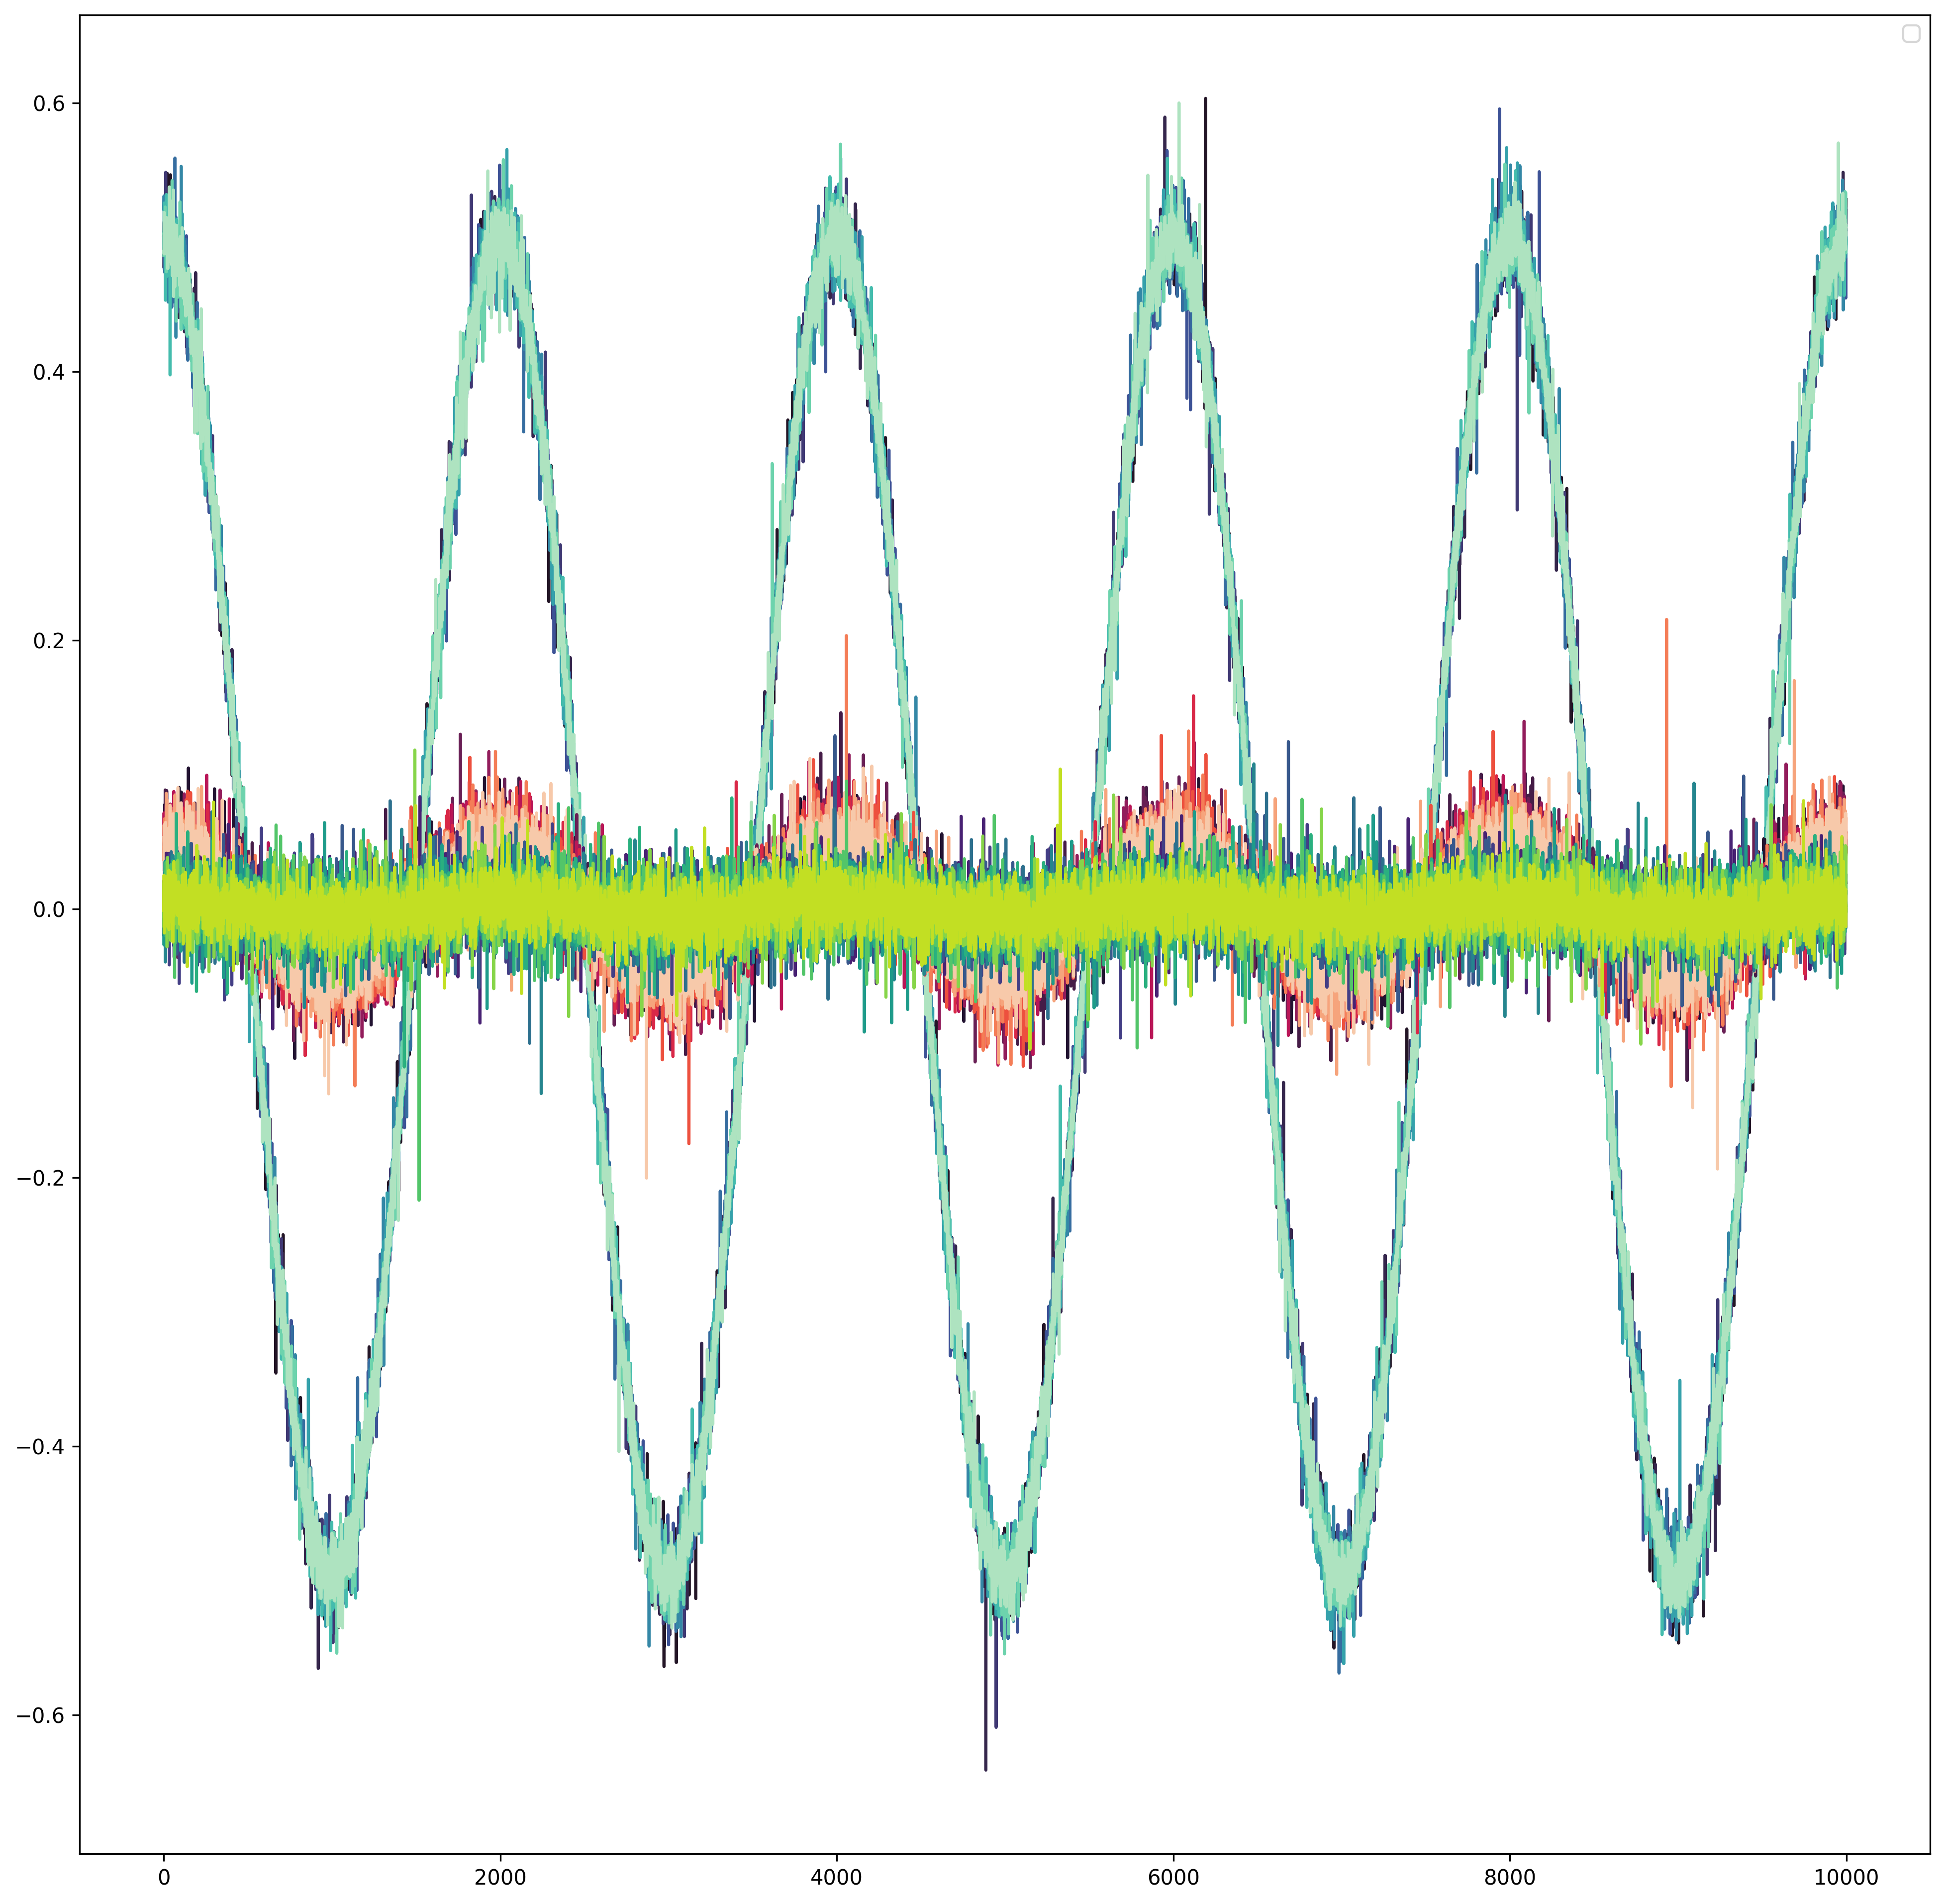

In [6]:
plt.figure(figsize=(16,16), dpi=300)
sns.lineplot(data=large_wave_gen.sample(10).T, palette='mako', dashes=False)
sns.lineplot(data=small_wave_gen.sample(10).T, palette='rocket', dashes=False)
sns.lineplot(data=flat_wave_gen.sample(10).T, palette='viridis', dashes=False)
plt.legend([])
plt.show()

In [7]:
dataset_samples = 10_000
dataset_dict = {
    1. : large_wave_gen.sample(dataset_samples),
    .5 : small_wave_gen.sample(dataset_samples),
    0. : flat_wave_gen.sample(dataset_samples),
}

from sklearn.model_selection import train_test_split

Xys = list()
for label, X in dataset_dict.items():
    assert X.shape[0] == dataset_samples
    y = np.full(dataset_samples, label).reshape(-1,1)
    Xy = np.concatenate([X, y], axis=1)
    display(Xy.shape)
    Xys.append(Xy)
    
Xy = np.concatenate(Xys, axis=0)
display(Xy.shape)

(10000, 10001)

(10000, 10001)

(10000, 10001)

(30000, 10001)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class SineCNN(nn.Module):
    def __init__(self, input_size, pool_kernel=4):
        super(SineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.maxpool = nn.MaxPool1d(kernel_size=pool_kernel)
        self.fc1 = nn.Linear((input_size - pool_kernel) // pool_kernel * 16, 32)
        self.dout1 = nn.Dropout(p=.4)
        self.fc2 = nn.Linear(32, 1)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dout1(x)
        x = self.fc2(x)
        x = self.output(x).squeeze()
        return x

model = SineCNN(Xy.shape[1] - 1).double()

In [ ]:
tensor_data = torch.from_numpy(Xy).double()
dataset = TensorDataset(tensor_data)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())
batch_size = 128
n_epochs = 100
items = list()

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(n_epochs):
    for batch in dataloader:
        batch = batch[0]
        inputs = batch[:,:-1] # sine waves
        labels = batch[:,-1:] # concat labels
        
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(axis=1)
        inputs = inputs.to(torch.float64)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)       
        loss.backward()
        optimizer.step()
        
        if not epoch // 100:
            print(loss.item())
        items.append(loss.item())
        
plt.figure(figsize=(16,8))
sns.lineplot(items, dashes=False, palette='Spectral')
plt.show()
assert False

torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.1894669481604869


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3857421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6640625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34374999999896994


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4150390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([16, 10000])

torch.Size([16, 1, 10000])

0.359375


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4873046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4199218749997041


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.640625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([16, 10000])

torch.Size([16, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6640625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.21875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.36327226363901344


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.1796875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([16, 10000])

torch.Size([16, 1, 10000])

0.6875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.59375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6015625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.265625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2734375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5859375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.53125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5703125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.34375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.25


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.6171875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4765625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2890625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5546875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5234375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.484375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4453125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4921875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.5078125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3046875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.28125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3671875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3203125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.40625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.390625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4296875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3359375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4140625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.515625


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.46875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.2578125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.421875


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.4609375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.328125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3984375


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

0.3828125


torch.Size([32, 10000])

torch.Size([32, 1, 10000])

In [ ]:
def base_wave(n_periods=1, phase_angle=0, arr_len=100):
    return np.sin(np.linspace(phase_angle,n_periods*np.pi*2+phase_angle,arr_len))

def bias_amplitude(arr, amplitude=.5, bias=.5):
    if amplitude != 1:
        arr = np.multiply(arr, amplitude)
    if bias:
        arr = np.add(arr, bias)
    return arr

def pixel_period(arr, pixel_period=.5):
    if 0 < period < 1:
        period = int(period * len(arr))
    arr = np.resize(arr, (period))
    return arr

def pad_wave(arr, pad_size, pad_split, ret_indices=True):
    assert round(sum(pad_split),3) == 1, f'pad_split {pad_split} must add to 1, not {sum(pad_split)}'
    assert len(pad_split) == 2
    left_pad_size = int(pad_size * pad_split[0])
    right_pad_size = pad_size - left_pad_size
    
    left_pad = np.zeros(left_pad_size)
    right_pad = np.zeros(right_pad_size)
    
    arr = np.concatenate((left_pad, arr, right_pad), axis=0)
    if ret_indices:
        indices = ~arr.astype(np.bool_)
        return arr, indices
    return arr

def pixel_wave(pixel_period, amplitude, bias, arr_len, pad_split=(.5,.5), **base_kwargs):
#     arr_len = base_kwargs['arr_len']
    if 0 < pixel_period < 1:
        pixel_period = int(pixel_period * len(arr_len))
#     base_kwargs['arr_len'] = pixel_period
    wave = base_wave(arr_len=pixel_period, **base_kwargs)
    wave = bias_amplitude(wave, amplitude=amplitude, bias=bias)
    
    pad_size = (arr_len - pixel_period)
    wave = pad_wave(wave, pad_size, pad_split)
    return wave

def verify_indices(indices, arr=None, pad_val=0):
    assert indices.ndim == 1
    assert indices.dtype == np.bool_
    if arr:
        assert arr.shape == indices.shape
        assert indices[arr == pad_val].all() == True
    return
    
def noise_patch(arr, indices, start, stop, **noise_kwargs):
    indices[start:stop] = True
    arr[start:stop] = add_noise(arr[start:stop], **noise_kwargs)
    return arr, indices
    
def add_edge_noise(arr, indices, start=0, stop=-1, size_range=(.05,.1), pad_val=0, ret_indices=True, **noise_kwargs):
    valid_size = len(indices)
    false_indices = np.where(indices==False)
    patch_min = np.amin(false_indices)
    patch_max = np.amax(false_indices)
    
    left_size = int(valid_size * np.random.uniform(*size_range))
    right_size = int(valid_size * np.random.uniform(*size_range))
    
    arr, indices = noise_patch(arr, indices, patch_min, patch_min + left_size, **noise_kwargs)
    arr, indices = noise_patch(arr, indices, patch_max - right_size, patch_max, **noise_kwargs)
    return arr, indices

def plot_wave(wave, indices=None, i=''):
    if isinstance(i, int): i = ' ' + str(i)
    plt.figure(figsize=(16,4), dpi=200)
    x=[i for i in range(len(wave))]
    assert wave.ndim == 1
    sns.lineplot(x=x, y=wave, label=f'Wave{i}')
    if indices is not None:
        verify_indices(indices)
        sns.lineplot(x=x, y=indices, label=f'Label{i}')
    plt.legend()
    plt.show()
    return

arr, indices = pixel_wave(120, .4, .5, 200)
plot_wave(arr)
slanted_arr = np.add(arr, np.linspace(0, len(arr)*.005, len(arr)))
plot_wave(slanted_arr)
arr, indices = add_edge_noise(arr, indices)
plot_wave(arr)
plot_wave(indices)

In [ ]:
wave = base_wave()
plot_wave(wave)

In [ ]:
ARG_STEPS = 20
amplitudes = np.arange(.1,1,ARG_STEPS)
pixel_periods = np.arange(60,SINE_LEN,ARG_STEPS)
phase_angles = np.arange(0,np.pi,ARG_STEPS)

y_list = list()
X_list = list()
for i, args in enumerate(itertools.product(amplitudes, pixel_periods, phase_angles)):
    y_list.append(np.repeat(args, NOISE_SAMPLES))
    amplitude, pixel_period, phase_angle = args
    X_list.append(
        np.vstack(
            [
                pixel_wave(
                    pixel_period, 
                    amplitude, 
                    .5, 
                    n_periods=1, 
                    phase_angle=phase_angle, 
                    arr_len=SINE_LEN
                ) 
                for _ 
                in range(NOISE_SAMPLES)
            ]
        )
    )
    if i % 1000 == 0:
        sns.lineplot(data=X_list[-1].transpose())
        plt.show()
        
y_train = np.concatenate(y_list, axis=0)
print(y_train.shape)
X_train = np.concatenate(X_list, axis=0)
print(X_train.shape)       

### Sinc Wave Generation

## Simple Keras Network

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Nadam
from keras.layers import LeakyReLU

# define the input 

In [ ]:
inputs = Input(shape=(SINE_LEN,))

def create_hidden(arr, neurons, alpha=.1):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    return arr

def create_output(arr, neurons, name):
    arr = Dense(neurons)(arr)
    arr = LeakyReLU(alpha=alpha)(arr)
    arr = Dense(1, name=name)(arr)
    return arr

hidden1 = create_hidden(inputs, 128)
hidden2 = create_hidden(hidden1, 64)
hidden3 = create_hidden(hidden2, 32)

# define the output layer
output1 = create_output(hidden3, 32, 'output1')
output2 = create_output(hidden3, 32, 'output2')

loss_weights = {'output1': 0.5, 'output2': 0.5}

model = Model(inputs=inputs, outputs=[output1, output2])
model.compile(loss='mean_squared_error', optimizer=Nadam(lr=0.002), loss_weights=loss_weights)
model.summary()

### Add Callbacks

## Duplicate PyTorch Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(SINE_LEN, 128),
            LeakyReLU(),
            nn.Linear(128, 64),
            LeakyReLU(),
            nn.Linear(64, 32),
            LeakyReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        output1 = self.model(x)
        output1 = self.output(output1)
        output2 = self.model(x)
        output2 = self.output(output2)
    
        return output1, output2

model = Net()
criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters())
for epoch in range(N_EPOCHS):
    inputs = X
    targets = X
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch} Loss: {loss}')

## Sine Wave Side to Side

## Sine Wave Single Period